<a href="https://colab.research.google.com/github/VesalAhsani/pytorch-Graph-Attention-Network-GAT/blob/main/original_GAT_paper_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this implementation, we utilized *igraph* while we had no idea it has problem in Jupyter. 
Thus, two graphs in visualization part couldn't be visualized here in Jupyter. 😤

BUT, the original **GAT** from its paper has been implemented perfectly !! 👍👍👍👍

# Graph Attention Network (GAT)


Graph Attention Network, or GAT for short, is a Graph Neural Network (GNN) published by `Veličković et al.` in a paper called [*Graph Attention Networks*](https://arxiv.org/abs/1710.10903) back in 2017.

It is actually made up of combining **attention** with the already existing **graphs convolutional networks** (GCN). Thus, it is important to understand GCNs in order to understand GAT. 

> `GCN + attention = GAT`

After the advent of CNN and its huge hype in the world of deep learning and solving numerous computer vision problems, scientist decided to make the same architecture for graphs.

The major difference between CNNs and GNNs is that CNNs are specially built to operate on regular (Euclidean) structured data, while GNNs are the generalized version of CNNs where the numbers of nodes connections **vary** and the nodes are **unordered** (irregular on non-Euclidean structured data).


Graph convolution come into two flavors: *spatial and spectral*.

**Spectral Convolution:** 

>In a spectral graph convolution, we perform an Eigen decomposition of the Laplacian Matrix of the graph. This Eigen decomposition helps us in understanding the underlying structure of the graph with which we can identify clusters/sub-groups of this graph. This is done in the Fourier space. An analogy is PCA where we understand the spread of the data by performing an Eigen Decomposition of the feature matrix. The only difference between these two methods is with respect to the Eigen values. Smaller Eigen values explain the structure of the data better in Spectral Convolution whereas it's the opposite in PCA. ChebNet, GCN are some commonly used Deep learning architectures that use Spectral Convolution

**Spatial Convolution:**
>Spatial Convolution works on local neighbourhood of nodes and understands the properties of a node based on its k local neighbours. Unlike Spectral Convolution which takes a lot of time to compute, Spatial Convolutions are simple and have produced state of the art results on graph classification tasks. GraphSage is a good example for Spatial Convolution.


**High level explanation of spatial (message passing) methods:** 

Having feature vectors from your neighbors:
1. Transform them (e.g. linear projection)
2. Aggregate them (e.g. weighing them with attention coefficients, we get GAT)
3. Update the feature vector of the current node by combining its (transformed) feature vector with the aggregated neighborhood representation.

Then many different GNNs can be fitted into this framework.



* Below you can see how GAT schematic looks like.

* *different colored edges represent different attention heads*


<img src="https://github.com/VesalAhsani/pytorch-Graph-Attention-Network-GAT/raw/main/pics/GAT.PNG" width=700 alt="figure 1 from the original vision transformer paper"/>

In [46]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx

try:
  import igraph as ig
except:
  !pip -q install igraph

from igraph import *

try:
  import cairocffi
except:
  !pip -q install cairocffi


import scipy.sparse as sp
import numpy as np

import torch

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [49]:
# Let's define constants which are needed for loading data and visualization
import os
import enum

# Supported datasets - only Cora in this notebook
class DatasetType(enum.Enum):
    CORA = 0

class GraphVisualizationTool(enum.Enum):
    NETWORKX = 0,
    IGRAPH = 1

# We'll be dumping and reading the data from this directory
# os.mkdir("data")
# os.mkdir("data/cora")
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')
CORA_PATH = os.path.join(DATA_DIR_PATH, 'cora') 


# Cora specific constants
# Below we use the method for splitting which has been used in GCN paper first, later used in GAT paper as well

CORA_TRAIN_RANGE = [0, 300]  # we're using the first 140 nodes as the training nodes
CORA_VAL_RANGE = [300, 300+500]
CORA_TEST_RANGE = [1708, 1708+1000]
CORA_NUM_INPUT_FEATURES = 1433
CORA_NUM_CLASSES = 7

# Used whenever we need to visualzie points from different classes (t-SNE, CORA visualization)
cora_label_to_color_map = {0: "blue", 1: "red", 2: "orange", 3: "green", 4: "pink", 5: "gray", 6: "yellow"}

## 1: data 

First, we should explain about the difference between `transductive` and `inductive` setting? 

> **Transductive** - you have a single graph (like Cora) and you split some **nodes** (and not graphs) into train/val/test sets. While you're training, you'll be using only the labels from your training nodes. But, During the forward prop, by the nature of how spatial GNNs work, you'll be aggregating the feature vectors from your neighbors and **some of them may belong to val or even test sets!** The main point is - you **ARE NOT** using their labels information but you **ARE** using the structural information and their features.

> **Inductive** - You have a set of training graphs, a separate sets of val graphs and test graphs.

In this notebook, we focus on Cora (a transductive example)

In [50]:
# First let's define simple functions for loading/saving Pickle files, needed for Cora
# All Cora data is stored as pickle
def pickle_read(path):
    with open(path, 'rb') as file:
        data = pickle.load(file)
    return data

def pickle_save(path, data):
    with open(path, 'wb') as file:
        pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

Now, it's time to load Cora!



In [51]:
# training config will be defined later
def load_graph_data(training_config, device):
    dataset_name = training_config['dataset_name'].lower()
    should_visualize = training_config['should_visualize']

    if dataset_name == DatasetType.CORA.name.lower():

        # shape = (N, FIN), where N is the number of nodes and FIN is the number of input features
        node_features_csr = pickle_read(os.path.join(CORA_PATH, 'node_features.csr'))
        # shape = (N, 1)
        node_labels_npy = pickle_read(os.path.join(CORA_PATH, 'node_labels.npy'))
        # shape = (N, number of neighboring nodes)
        adjacency_list_dict = pickle_read(os.path.join(CORA_PATH, 'adjacency_list.dict'))

        # Normalizing the features (helps with training)
        node_features_csr = normalize_features_sparse(node_features_csr)
        num_of_nodes = len(node_labels_npy)

        # shape = (2, E), where E is the number of edges, and 2 for source and target nodes. Basically edge index
        # contains tuples of the format S->T, e.g. 0->3 means that node with id 0 points to a node with id 3.
        topology = build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True)

        # Note: topology is just a fancy way of naming the graph structure data 
        # (aside from edge index it could be in the form of an adjacency matrix)

        if should_visualize:  # network analysis and graph drawing
            plot_in_out_degree_distributions(topology, num_of_nodes, dataset_name)  # we'll define these in a second
            visualize_graph(topology, node_labels_npy, dataset_name)

        # Convert to dense PyTorch tensors

        # Needs to be long int type because later functions like PyTorch's index_select expect it
        topology = torch.tensor(topology, dtype=torch.long, device=device)
        node_labels = torch.tensor(node_labels_npy, dtype=torch.long, device=device)  # Cross entropy expects a long int
        node_features = torch.tensor(node_features_csr.todense(), device=device)

        # Indices that help us extract nodes that belong to the train/val and test splits
        train_indices = torch.arange(CORA_TRAIN_RANGE[0], CORA_TRAIN_RANGE[1], dtype=torch.long, device=device)
        val_indices = torch.arange(CORA_VAL_RANGE[0], CORA_VAL_RANGE[1], dtype=torch.long, device=device)
        test_indices = torch.arange(CORA_TEST_RANGE[0], CORA_TEST_RANGE[1], dtype=torch.long, device=device)

        return node_features, node_labels, topology, train_indices, val_indices, test_indices
    else:
        raise Exception(f'{dataset_name} not yet supported.')

### **Feature Normalization** on Cora

It's basically making Cora's binary node feature vectors sum up to 1. For instance, if we had `[1, 0, 1, 0, 1]` (Cora's feature vectors are longer as we'll soon see but let's take this one for the time being), it will get transformed into `[0.33, 0, 0.33, 0, 0.33]`.

In [52]:
def normalize_features_sparse(node_features_sparse):
    assert sp.issparse(node_features_sparse), f'Expected a sparse matrix, got {node_features_sparse}.'

    # Instead of dividing (like in normalize_features_dense()) we do multiplication with inverse sum of features.
    # shape = (N, FIN) -> (N, 1), where N number of nodes and FIN number of input features
    node_features_sum = np.array(node_features_sparse.sum(-1))  # sum features for every node feature vector

    # Make an inverse (remember * by 1/x is better (faster) then / by x)
    # shape = (N, 1) -> (N)
    node_features_inv_sum = np.power(node_features_sum, -1).squeeze()

    # Again certain sums will be 0 so 1/0 will give us infinite so we replace those by 1 which is a neutral element for mul
    node_features_inv_sum[np.isinf(node_features_inv_sum)] = 1.

    # Create a diagonal matrix whose values on the diagonal come from node_features_inv_sum
    diagonal_inv_features_sum_matrix = sp.diags(node_features_inv_sum)

    # We return the normalized features.
    return diagonal_inv_features_sum_matrix.dot(node_features_sparse)


### **Edge Index**

we accumulate the edges in this format:

[[0, 1], [2, 2], ...] where [s, t] tuple basically defines an edge where node `s` (source) points to node `t` (target).

There are other popular formats which I will be used in the 2 other implementations. That's **adjacency matrix** - but those take up way more memory (O(N^2) to be precise, compare that to O(E) for the edge index structure).


In [53]:
def build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True):
    source_nodes_ids, target_nodes_ids = [], []
    seen_edges = set()

    for src_node, neighboring_nodes in adjacency_list_dict.items():
        for trg_node in neighboring_nodes:
            # if this edge hasn't been seen so far we add it to the edge index (coalescing - removing duplicates)
            if (src_node, trg_node) not in seen_edges:  # it would be easy to explicitly remove self-edges (Cora has none..)
                source_nodes_ids.append(src_node)
                target_nodes_ids.append(trg_node)

                seen_edges.add((src_node, trg_node))

    if add_self_edges:
        source_nodes_ids.extend(np.arange(num_of_nodes))
        target_nodes_ids.extend(np.arange(num_of_nodes))

    # shape = (2, E), where E is the number of edges in the graph
    edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))

    return edge_index

In [54]:
# define dummy visualization functions 
def plot_in_out_degree_distributions():
    pass

def visualize_graph():
    pass

device = "cuda" if torch.cuda.is_available() else "cpu"  # checking whether you have a GPU

config = {
    'dataset_name': DatasetType.CORA.name,
    'should_visualize': False
}

node_features, node_labels, edge_index, train_indices, val_indices, test_indices = load_graph_data(config, device)

print(f"the size of node_features: {node_features.shape}")
print(f"the size of node_labels: {node_labels.shape}")
print(f"the size of edge_index: {edge_index.shape}")
print(f"the size of train_indices: {train_indices.shape}")
print(f"the size of val_indices: {val_indices.shape}")
print(f"the size of test_indices: {test_indices.shape}")

the size of node_features: torch.Size([2708, 1433])
the size of node_labels: torch.Size([2708])
the size of edge_index: torch.Size([2, 13264])
the size of train_indices: torch.Size([300])
the size of val_indices: torch.Size([500])
the size of test_indices: torch.Size([1000])


Quick analysis:

1. Cora has 2708 nodes
2. Each node has 1433 features
3. We have 13264 edges! (including the self edges)
4. We have 140 training nodes
5. We have 500 val nodes
6. We have 1000 test nodes


### Visualize, visualize, visualize

By visualization, we can grasp more understanding of the degree distribution of nodes in Cora - i.e. how many input/output edges do nodes have, a certain measure of connectedness of the graph.



In [55]:
def plot_in_out_degree_distributions(edge_index, num_of_nodes, dataset_name):

    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.cpu().numpy()
        
    assert isinstance(edge_index, np.ndarray), f'Expected NumPy array got {type(edge_index)}.'

    # Store each node's input and output degree 
    # undirected graphs such as Cora have same input and output degree
    in_degrees = np.zeros(num_of_nodes, dtype=np.int)
    out_degrees = np.zeros(num_of_nodes, dtype=np.int)

    # Edge index shape = (2, E), the first row contains the source nodes, the second one target/sink nodes
    # Note on terminology: source nodes point to target/sink nodes
    num_of_edges = edge_index.shape[1]
    
    for num in range(num_of_edges):
        source_node_id = edge_index[0, num]
        target_node_id = edge_index[1, num]

        out_degrees[source_node_id] += 1  
        in_degrees[target_node_id] += 1 

    hist = np.zeros(np.max(out_degrees) + 1)
    for out_degree in out_degrees:
        hist[out_degree] += 1

    fig = plt.figure(figsize=(12,8), dpi=100)
    fig.subplots_adjust(hspace=0.6)

    plt.subplot(311)
    plt.plot(in_degrees, color='blue')
    plt.xlabel('node id'); plt.ylabel('No. of in-degree'); plt.title('In degree')

    plt.subplot(312)
    plt.plot(out_degrees, color='red')
    plt.xlabel('node id'); plt.ylabel('No. of out-degree'); plt.title('Out degree')

    plt.subplot(313)
    plt.plot(hist, color='green')
    plt.xlabel('degree of nodes')
    plt.ylabel('# nodes for a given out-degree') 
    plt.title(f'Distribution of node out-degree for {dataset_name} dataset')
    plt.xticks(np.arange(0, len(hist), 5.0))

    plt.grid(True)
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

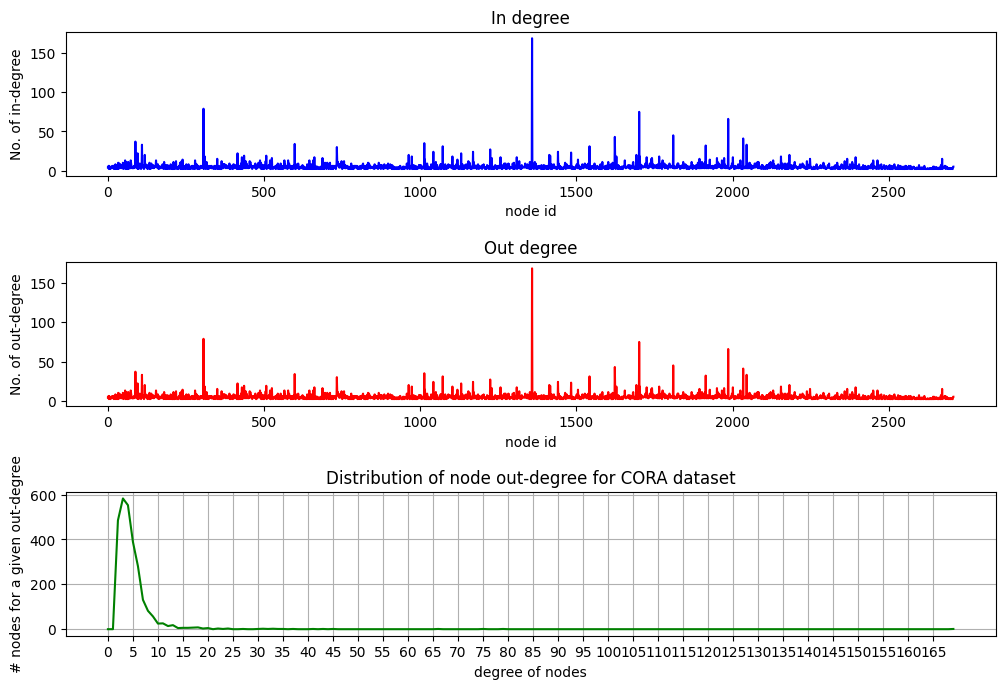

In [56]:
num_of_nodes = len(node_labels)

plot_in_out_degree_distributions(edge_index, num_of_nodes, config['dataset_name'])

Discussion:

* The top 2 plots are the same, because we treat Cora as an undirected graph (even though it should naturally be modeled as a directed graph)
* Certain nodes have a huge number of edges (the peak in the middle) but most nodes have far less edges
* The third plot nicely visualizes this in the form of a histogram - most nodes have only `2-5` edges (thus the peak on the leftmost side)

In [57]:
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libcairo2-dev is already the newest version (1.15.10-2ubuntu0.1).
libgif-dev is already the newest version (5.1.4-2ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
import cairo

In [59]:
### igraph is having some problems with Jupyter Notebook... It only gives error here in jupyter :(

In [ ]:
dataset_name = config['dataset_name']
visualization_tool=GraphVisualizationTool.IGRAPH

if isinstance(edge_index, torch.Tensor):
    edge_index_np = edge_index.cpu().numpy()

if isinstance(node_labels, torch.Tensor):
    node_labels_np = node_labels.cpu().numpy()

num_of_nodes = len(node_labels_np)
edge_index_tuples = list(zip(edge_index_np[0, :], edge_index_np[1, :]))  # igraph requires this format

# Construct the igraph graph
ig_graph = ig.Graph()
ig_graph.add_vertices(num_of_nodes)
ig_graph.add_edges(edge_index_tuples)

# Prepare the visualization settings dictionary
visual_style = {}

visual_style["bbox"] = (3000, 3000)
visual_style["margin"] = 5

edge_weights_raw = np.clip(np.log(np.asarray(ig_graph.edge_betweenness())+1e-16), a_min=0, a_max=None)
edge_weights_raw_normalized = edge_weights_raw / np.max(edge_weights_raw)
edge_weights = [w**6 for w in edge_weights_raw_normalized]
visual_style["edge_width"] = edge_weights

# A simple heuristic for vertex size. Size ~ (degree / 4) (it gave nice results I tried log and sqrt as well)
visual_style["vertex_size"] = [deg / 4 for deg in ig_graph.degree()]

# This is the only part that's Cora specific as Cora has 7 labels
if dataset_name.lower() == DatasetType.CORA.name.lower():
    visual_style["vertex_color"] = [cora_label_to_color_map[label] for label in node_labels_np]
else:
    print('Feel free to add custom color scheme for your specific dataset. Using igraph default coloring.')

# Set the layout - the way the graph is presented on a 2D chart. Graph drawing is a subfield for itself!
# I used "Kamada Kawai" a force-directed method, this family of methods are based on physical system simulation.
# (layout_drl also gave nice results for Cora)
visual_style["layout"] = ig_graph.layout_kamada_kawai()

print('Plotting results ... (it may take couple of seconds).')
ig.plot(ig_graph, **visual_style)

##2: Pre-training


In [61]:
import torch.nn as nn
from torch.optim import Adam


class GAT(torch.nn.Module):
    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, add_skip_connection=True, bias=True,
                 dropout=0.6, log_attention_weights=False):
        super().__init__()
        assert num_of_layers == len(num_heads_per_layer) == len(num_features_per_layer) - 1, f'Enter valid arch params.'

        num_heads_per_layer = [1] + num_heads_per_layer 

        # collect GAT layers
        gat_layers = []  
        for i in range(num_of_layers):
            layer = GATLayer(
                num_in_features=num_features_per_layer[i] * num_heads_per_layer[i], 
                num_out_features=num_features_per_layer[i+1],
                num_of_heads=num_heads_per_layer[i+1],
                concat=True if i < num_of_layers - 1 else False,  # last GAT layer does mean avg, the others do concat
                activation=nn.ELU() if i < num_of_layers - 1 else None,  # last layer just outputs raw scores
                dropout_prob=dropout,
                add_skip_connection=add_skip_connection,
                bias=bias,
                log_attention_weights=log_attention_weights
            )
            gat_layers.append(layer)

        self.gat_net = nn.Sequential(
            *gat_layers,
        )

    def forward(self, data):
        return self.gat_net(data)

In [62]:
class GATLayer(torch.nn.Module):
    """
    it is inspired by PyTorch Geometric: https://github.com/rusty1s/pytorch_geometric

    """
    src_nodes_dim = 0  # position of source nodes in edge index
    trg_nodes_dim = 1  # position of target nodes in edge index

    # These may change in the inductive setting - leaving it like this for now (not future proof)
    nodes_dim = 0     
    head_dim = 1      

    def __init__(self, num_in_features, num_out_features, num_of_heads, concat=True, activation=nn.ELU(),
                 dropout_prob=0.6, add_skip_connection=True, bias=True, log_attention_weights=False):

        super().__init__()

        self.num_of_heads = num_of_heads
        self.num_out_features = num_out_features
        self.concat = concat  # whether we should concatenate or average the attention heads
        self.add_skip_connection = add_skip_connection

        #
        # Trainable weights: linear projection matrix (denoted as "W" in the paper), attention target/source
        # (denoted as "a" in the paper) and bias (not mentioned in the paper but present in the official GAT repo)
        #

        # You can treat this one matrix as num_of_heads independent W matrices
        self.linear_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)

        # After we concatenate target node (node i) and source node (node j) we apply the "additive" scoring function
        # which gives us un-normalized score "e". Here we split the "a" vector - but the semantics remain the same.
        # Basically instead of doing [x, y] (concatenation, x/y are node feature vectors) and dot product with "a"
        # we instead do a dot product between x and "a_left" and y and "a_right" and we sum them up
        self.scoring_fn_target = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        self.scoring_fn_source = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))

        # Bias is not necessary to GAT - feel free to experiment
        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(num_of_heads * num_out_features))
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(num_out_features))
        else:
            self.register_parameter('bias', None)

        if add_skip_connection:
            self.skip_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        else:
            self.register_parameter('skip_proj', None)

        # End of trainable weights
        

        self.leakyReLU = nn.LeakyReLU(0.2)  # using 0.2 as in the paper
        self.activation = activation
        self.dropout = nn.Dropout(p=dropout_prob)

        self.log_attention_weights = log_attention_weights 
        self.attention_weights = None 

        self.init_params()
        
    def forward(self, data):
        
        # Step 1: Linear Projection + regularization
        

        in_nodes_features, edge_index = data  # unpack data
        num_of_nodes = in_nodes_features.shape[self.nodes_dim]
        assert edge_index.shape[0] == 2, f'Expected edge index with shape=(2,E) got {edge_index.shape}'

        # We apply the dropout to all of the input node features (as mentioned in the paper)
        in_nodes_features = self.dropout(in_nodes_features)

        # shape = (N, FIN) * (FIN, NH*FOUT) -> (N, NH, FOUT) where NH - number of heads, FOUT - num of output features
        # We project the input node features into NH independent output features (one for each attention head)
        nodes_features_proj = self.linear_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        nodes_features_proj = self.dropout(nodes_features_proj)

        # Step 2: Edge attention calculation

        # Apply the scoring function
        # shape = (N, NH, FOUT) * (1, NH, FOUT) -> (N, NH, 1) -> (N, NH) because sum squeezes the last dimension
        # Optimization note: torch.sum() is as performant as .sum()
        scores_source = (nodes_features_proj * self.scoring_fn_source).sum(dim=-1)
        scores_target = (nodes_features_proj * self.scoring_fn_target).sum(dim=-1)

        # scores shape = (E, NH), nodes_features_proj_lifted shape = (E, NH, FOUT), E - number of edges in the graph
        scores_source_lifted, scores_target_lifted, nodes_features_proj_lifted = self.lift(scores_source, scores_target, nodes_features_proj, edge_index)
        scores_per_edge = self.leakyReLU(scores_source_lifted + scores_target_lifted)

        # shape = (E, NH, 1)
        attentions_per_edge = self.neighborhood_aware_softmax(scores_per_edge, edge_index[self.trg_nodes_dim], num_of_nodes)
        # Add stochasticity to neighborhood aggregation
        attentions_per_edge = self.dropout(attentions_per_edge)

        # Step 3: Neighborhood aggregation

        # Element-wise (aka Hadamard) product. Operator * does the same thing as torch.mul
        # shape = (E, NH, FOUT) * (E, NH, 1) -> (E, NH, FOUT), 1 gets broadcast into FOUT
        nodes_features_proj_lifted_weighted = nodes_features_proj_lifted * attentions_per_edge

        # This part sums up weighted and projected neighborhood feature vectors for every target node
        # shape = (N, NH, FOUT)
        out_nodes_features = self.aggregate_neighbors(nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes)

        # Step 4: Residual/skip connections, concat and bias

        out_nodes_features = self.skip_concat_bias(attentions_per_edge, in_nodes_features, out_nodes_features)
        return (out_nodes_features, edge_index)
    

    def neighborhood_aware_softmax(self, scores_per_edge, trg_index, num_of_nodes):
        """
        As the fn name suggest it does softmax over the neighborhoods. Example: say we have 5 nodes in a graph.
        Two of them 1, 2 are connected to node 3. If we want to calculate the representation for node 3 we should take
        into account feature vectors of 1, 2 and 3 itself. Since we have scores for edges 1-3, 2-3 and 3-3
        in scores_per_edge variable, this function will calculate attention scores like this: 1-3/(1-3+2-3+3-3)
        (where 1-3 is overloaded notation it represents the edge 1-3 and its (exp) score) and similarly for 2-3 and 3-3
         i.e. for this neighborhood we don't care about other edge scores that include nodes 4 and 5.

        Note:
        Subtracting the max value from logits doesn't change the end result but it improves the numerical stability
        and it's a fairly common "trick" used in pretty much every deep learning framework.
        Check out this link for more details:

        https://stats.stackexchange.com/questions/338285/how-does-the-subtraction-of-the-logit-maximum-improve-learning

        """
        # Calculate the numerator. Make logits <= 0 so that e^logit <= 1 (this will improve the numerical stability)
        scores_per_edge = scores_per_edge - scores_per_edge.max()
        exp_scores_per_edge = scores_per_edge.exp()  # softmax

        # Calculate the denominator. shape = (E, NH)
        neigborhood_aware_denominator = self.sum_edge_scores_neighborhood_aware(exp_scores_per_edge, trg_index, num_of_nodes)

        # 1e-16 is theoretically not needed but is only there for numerical stability (avoid div by 0) - due to the
        # possibility of the computer rounding a very small number all the way to 0.
        attentions_per_edge = exp_scores_per_edge / (neigborhood_aware_denominator + 1e-16)

        # shape = (E, NH) -> (E, NH, 1) so that we can do element-wise multiplication with projected node features
        return attentions_per_edge.unsqueeze(-1)

    def sum_edge_scores_neighborhood_aware(self, exp_scores_per_edge, trg_index, num_of_nodes):
        # The shape must be the same as in exp_scores_per_edge (required by scatter_add_) i.e. from E -> (E, NH)
        trg_index_broadcasted = self.explicit_broadcast(trg_index, exp_scores_per_edge)

        # shape = (N, NH), where N is the number of nodes and NH the number of attention heads
        size = list(exp_scores_per_edge.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes
        neighborhood_sums = torch.zeros(size, dtype=exp_scores_per_edge.dtype, device=exp_scores_per_edge.device)

        # position i will contain a sum of exp scores of all the nodes that point to the node i (as dictated by the
        # target index)
        neighborhood_sums.scatter_add_(self.nodes_dim, trg_index_broadcasted, exp_scores_per_edge)

        # Expand again so that we can use it as a softmax denominator. e.g. node i's sum will be copied to
        # all the locations where the source nodes pointed to i (as dictated by the target index)
        # shape = (N, NH) -> (E, NH)
        return neighborhood_sums.index_select(self.nodes_dim, trg_index)

    def aggregate_neighbors(self, nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes):
        size = list(nodes_features_proj_lifted_weighted.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes  # shape = (N, NH, FOUT)
        out_nodes_features = torch.zeros(size, dtype=in_nodes_features.dtype, device=in_nodes_features.device)

        # shape = (E) -> (E, NH, FOUT)
        trg_index_broadcasted = self.explicit_broadcast(edge_index[self.trg_nodes_dim], nodes_features_proj_lifted_weighted)
        # aggregation step - we accumulate projected, weighted node features for all the attention heads
        # shape = (E, NH, FOUT) -> (N, NH, FOUT)
        out_nodes_features.scatter_add_(self.nodes_dim, trg_index_broadcasted, nodes_features_proj_lifted_weighted)

        return out_nodes_features

    def lift(self, scores_source, scores_target, nodes_features_matrix_proj, edge_index):
        """
        Lifts i.e. duplicates certain vectors depending on the edge index.
        One of the tensor dims goes from N -> E (that's where the "lift" comes from).

        """
        src_nodes_index = edge_index[self.src_nodes_dim]
        trg_nodes_index = edge_index[self.trg_nodes_dim]

        # Using index_select is faster than "normal" indexing (scores_source[src_nodes_index]) in PyTorch!
        scores_source = scores_source.index_select(self.nodes_dim, src_nodes_index)
        scores_target = scores_target.index_select(self.nodes_dim, trg_nodes_index)
        nodes_features_matrix_proj_lifted = nodes_features_matrix_proj.index_select(self.nodes_dim, src_nodes_index)

        return scores_source, scores_target, nodes_features_matrix_proj_lifted

    def explicit_broadcast(self, this, other):
        # Append singleton dimensions until this.dim() == other.dim()
        for _ in range(this.dim(), other.dim()):
            this = this.unsqueeze(-1)

        # Explicitly expand so that shapes are the same
        return this.expand_as(other)

    def init_params(self):
        """
        The reason we're using Glorot (aka Xavier uniform) initialization is because it's a default TF initialization:
            https://stackoverflow.com/questions/37350131/what-is-the-default-variable-initializer-in-tensorflow

        The original repo was developed in TensorFlow (TF) and they used the default initialization.
        Feel free to experiment - there may be better initializations depending on your problem.

        """
        nn.init.xavier_uniform_(self.linear_proj.weight)
        nn.init.xavier_uniform_(self.scoring_fn_target)
        nn.init.xavier_uniform_(self.scoring_fn_source)

        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def skip_concat_bias(self, attention_coefficients, in_nodes_features, out_nodes_features):
        if self.log_attention_weights:  # potentially log for later visualization in playground.py
            self.attention_weights = attention_coefficients

        if self.add_skip_connection:  # add skip or residual connection
            if out_nodes_features.shape[-1] == in_nodes_features.shape[-1]:  # if FIN == FOUT
                # unsqueeze does this: (N, FIN) -> (N, 1, FIN), out features are (N, NH, FOUT) so 1 gets broadcast to NH
                # thus we're basically copying input vectors NH times and adding to processed vectors
                out_nodes_features += in_nodes_features.unsqueeze(1)
            else:
                # FIN != FOUT so we need to project input feature vectors into dimension that can be added to output
                # feature vectors. skip_proj adds lots of additional capacity which may cause overfitting.
                out_nodes_features += self.skip_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        if self.concat:
            # shape = (N, NH, FOUT) -> (N, NH*FOUT)
            out_nodes_features = out_nodes_features.view(-1, self.num_of_heads * self.num_out_features)
        else:
            # shape = (N, NH, FOUT) -> (N, FOUT)
            out_nodes_features = out_nodes_features.mean(dim=self.head_dim)

        if self.bias is not None:
            out_nodes_features += self.bias

        return out_nodes_features if self.activation is None else self.activation(out_nodes_features)

>The main idea leading to huge savings is that we calculate the scores only for the nodes that will actually be used and not for every imaginable combination (*that would be valid only in a fully-connected graph*).

>Once we compute the `"left"` scores and the `"right"` scores, we "lift" them up using the edge index. Accordingly, 
if the edge `1->2` is not present in the graph we won't have those score pairs in our data structure.

>After adding lifted "left" and "right" (or maybe a better naming would be source and target) scores we do smart `neighborhood-aware softmax` - so that the semantics of GAT is respected. After doing the `scatter add`, we can combine the projected feature vectors.


## 3: Training

First let's define some relevant constants. 

In [63]:
from torch.utils.tensorboard import SummaryWriter


# 3 different model training/eval phases used in train.py
class LoopPhase(enum.Enum):
    TRAIN = 0,
    VAL = 1,
    TEST = 2

    
writer = SummaryWriter()  # (tensorboard) writer will output to ./runs/ directory by default


# Global vars used for early stopping. After some number of epochs (as defined by the patience_period var) without any
# improvement on the validation dataset (measured via accuracy metric), we'll break out from the training loop.
BEST_VAL_ACC = 0
BEST_VAL_LOSS = 0
PATIENCE_CNT = 0

BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries')
CHECKPOINTS_PATH = os.path.join(os.getcwd(), 'models', 'checkpoints')

# Make sure these exist as the rest of the code assumes it
os.makedirs(BINARIES_PATH, exist_ok=True)
os.makedirs(CHECKPOINTS_PATH, exist_ok=True)

In [64]:
try:
  import git
except:
  !pip -q install GitPython
  import git

import re  # regex


def get_training_state(training_config, model):
    training_state = {
        # "commit_hash": git.Repo(search_parent_directories=True).head.object.hexsha,

        # Training details
        "dataset_name": training_config['dataset_name'],
        "num_of_epochs": training_config['num_of_epochs'],
        "test_acc": training_config['test_acc'],

        # Model structure
        "num_of_layers": training_config['num_of_layers'],
        "num_heads_per_layer": training_config['num_heads_per_layer'],
        "num_features_per_layer": training_config['num_features_per_layer'],
        "add_skip_connection": training_config['add_skip_connection'],
        "bias": training_config['bias'],
        "dropout": training_config['dropout'],

        # Model state
        "state_dict": model.state_dict()
    }

    return training_state


def print_model_metadata(training_state):
    header = f'\n{"*"*5} Model training metadata: {"*"*5}'
    print(header)

    for key, value in training_state.items():
        if key != 'state_dict':  # don't print state_dict just a bunch of numbers...
            print(f'{key}: {value}')
    print(f'{"*" * len(header)}\n')


def get_available_binary_name():
    prefix = 'gat'

    def valid_binary_name(binary_name):
        pattern = re.compile(rf'{prefix}_[0-9]{{6}}\.pth')
        return re.fullmatch(pattern, binary_name) is not None

    # Just list the existing binaries so that we don't overwrite them but write to a new one
    valid_binary_names = list(filter(valid_binary_name, os.listdir(BINARIES_PATH)))
    if len(valid_binary_names) > 0:
        last_binary_name = sorted(valid_binary_names)[-1]
        new_suffix = int(last_binary_name.split('.')[0][-6:]) + 1  # increment by 1
        return f'{prefix}_{str(new_suffix).zfill(6)}.pth'
    else:
        return f'{prefix}_000000.pth'

Now `argparse` is a nice way to **organize** your program settings:

In [65]:
import argparse


def get_training_args():
    parser = argparse.ArgumentParser()

    # Training related
    parser.add_argument("--num_of_epochs", type=int, help="number of training epochs", default=10000)
    parser.add_argument("--patience_period", type=int, help="number of epochs with no improvement on val before terminating", default=1000)
    parser.add_argument("--lr", type=float, help="model learning rate", default=5e-3)
    parser.add_argument("--weight_decay", type=float, help="L2 regularization on model weights", default=5e-4)
    parser.add_argument("--should_test", type=bool, help='should test the model on the test dataset?', default=True)

    # Dataset related
    parser.add_argument("--dataset_name", choices=[el.name for el in DatasetType], help='dataset to use for training', default=DatasetType.CORA.name)
    parser.add_argument("--should_visualize", type=bool, help='should visualize the dataset?', default=False)

    # Logging/debugging/checkpoint related (helps a lot with experimentation)
    parser.add_argument("--enable_tensorboard", type=bool, help="enable tensorboard logging", default=False)
    parser.add_argument("--console_log_freq", type=int, help="log to output console (epoch) freq (None for no logging)", default=100)
    parser.add_argument("--checkpoint_freq", type=int, help="checkpoint model saving (epoch) freq (None for no logging)", default=1000)
    args = parser.parse_args("")

    # Model architecture related - this is the architecture as defined in the official paper (for Cora classification)
    gat_config = {
        "num_of_layers": 2,  # GNNs, contrary to CNNs, are often shallow (it ultimately depends on the graph properties)
        "num_heads_per_layer": [8, 1],
        "num_features_per_layer": [CORA_NUM_INPUT_FEATURES, 8, CORA_NUM_CLASSES],
        "add_skip_connection": False, 
        "bias": True,  # result is not so sensitive to bias
        "dropout": 0.6,  # result is sensitive to dropout
    }

    # Wrapping training configuration into a dictionary
    training_config = dict()
    for arg in vars(args):
        training_config[arg] = getattr(args, arg)

    # Add additional config information
    training_config.update(gat_config)

    return training_config

In [66]:
import time


def train_gat(config):
    global BEST_VAL_ACC, BEST_VAL_LOSS

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Step 1: load the graph data
    node_features, node_labels, edge_index, train_indices, val_indices, test_indices = load_graph_data(config, device)

    # Step 2: prepare the model
    gat = GAT(
        num_of_layers=config['num_of_layers'],
        num_heads_per_layer=config['num_heads_per_layer'],
        num_features_per_layer=config['num_features_per_layer'],
        add_skip_connection=config['add_skip_connection'],
        bias=config['bias'],
        dropout=config['dropout'],
        log_attention_weights=False
    ).to(device)

    # Step 3: Prepare other training related utilities (loss & optimizer and decorator function)
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = Adam(gat.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    # The decorator function makes things cleaner since there is a lot of redundancy between the train and val loops
    main_loop = get_main_loop(
        config,
        gat,
        loss_fn,
        optimizer,
        node_features,
        node_labels,
        edge_index,
        train_indices,
        val_indices,
        test_indices,
        config['patience_period'],
        time.time())

    BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT = [0, 0, 0]  # reset vars used for early stopping

    # Step 4: Start the training procedure
    for epoch in range(config['num_of_epochs']):
        # Training loop
        main_loop(phase=LoopPhase.TRAIN, epoch=epoch)

        # Validation loop
        with torch.no_grad():
            try:
                main_loop(phase=LoopPhase.VAL, epoch=epoch)
            except Exception as e:  # "patience has run out" exception :O
                print(str(e))
                break  # break out from the training loop

    # Step 5: Potentially test your model
    # Don't overfit to the test dataset 
    if config['should_test']:
        test_acc = main_loop(phase=LoopPhase.TEST)
        config['test_acc'] = test_acc
        print(f'Test accuracy = {test_acc}')
    else:
        config['test_acc'] = -1

    # Save the latest GAT in the binaries directory
    torch.save(get_training_state(config, gat), os.path.join(BINARIES_PATH, get_available_binary_name()))

In [67]:
# Simple decorator function so that I don't have to pass arguments that don't change from epoch to epoch
def get_main_loop(config, gat, cross_entropy_loss, optimizer, node_features, node_labels, edge_index, train_indices, val_indices, test_indices, patience_period, time_start):

    node_dim = 0  # this will likely change as soon as we add an inductive example (Cora is transductive)

    train_labels = node_labels.index_select(node_dim, train_indices)
    val_labels = node_labels.index_select(node_dim, val_indices)
    test_labels = node_labels.index_select(node_dim, test_indices)

    # node_features shape = (N, FIN), edge_index shape = (2, E)
    graph_data = (node_features, edge_index)  # I pack data into tuples because GAT uses nn.Sequential which requires it

    def get_node_indices(phase):
        if phase == LoopPhase.TRAIN:
            return train_indices
        elif phase == LoopPhase.VAL:
            return val_indices
        else:
            return test_indices

    def get_node_labels(phase):
        if phase == LoopPhase.TRAIN:
            return train_labels
        elif phase == LoopPhase.VAL:
            return val_labels
        else:
            return test_labels

    def main_loop(phase, epoch=0):
        global BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT, writer

        # Certain modules behave differently depending on whether we're training the model or not.
        # e.g. nn.Dropout - we only want to drop model weights during the training.
        if phase == LoopPhase.TRAIN:
            gat.train()
        else:
            gat.eval()

        node_indices = get_node_indices(phase)
        gt_node_labels = get_node_labels(phase)  # gt stands for ground truth

        # Do a forwards pass and extract only the relevant node scores (train/val or test ones)
        # Note: [0] just extracts the node_features part of the data (index 1 contains the edge_index)
        # shape = (N, C) where N is the number of nodes in the split (train/val/test) and C is the number of classes
        nodes_unnormalized_scores = gat(graph_data)[0].index_select(node_dim, node_indices)

        # Example: let's take an output for a single node on Cora - it's a vector of size 7 and it contains unnormalized
        # scores like: V = [-1.393,  3.0765, -2.4445,  9.6219,  2.1658, -5.5243, -4.6247]
        # What PyTorch's cross entropy loss does is for every such vector it first applies a softmax, and so we'll
        # have the V transformed into: [1.6421e-05, 1.4338e-03, 5.7378e-06, 0.99797, 5.7673e-04, 2.6376e-07, 6.4848e-07]
        # secondly, whatever the correct class is (say it's 3), it will then take the element at position 3,
        # 0.99797 in this case, and the loss will be -log(0.99797). It does this for every node and applies a mean.
        # You can see that as the probability of the correct class for most nodes approaches 1 we get to 0 loss!
        loss = cross_entropy_loss(nodes_unnormalized_scores, gt_node_labels)

        if phase == LoopPhase.TRAIN:
            optimizer.zero_grad()  # clean the trainable weights gradients in the computational graph (.grad fields)
            loss.backward()  # compute the gradients for every trainable weight in the computational graph
            optimizer.step()  # apply the gradients to weights

        # Finds the index of maximum (unnormalized) score for every node and that's the class prediction for that node.
        # Compare those to true (ground truth) labels and find the fraction of correct predictions -> accuracy metric.
        class_predictions = torch.argmax(nodes_unnormalized_scores, dim=-1)
        accuracy = torch.sum(torch.eq(class_predictions, gt_node_labels).long()).item() / len(gt_node_labels)

        # Logging        

        if phase == LoopPhase.TRAIN:
            # Log metrics
            if config['enable_tensorboard']:
                writer.add_scalar('training_loss', loss.item(), epoch)
                writer.add_scalar('training_acc', accuracy, epoch)

            # Save model checkpoint
            if config['checkpoint_freq'] is not None and (epoch + 1) % config['checkpoint_freq'] == 0:
                ckpt_model_name = f"gat_ckpt_epoch_{epoch + 1}.pth"
                config['test_acc'] = -1
                torch.save(get_training_state(config, gat), os.path.join(CHECKPOINTS_PATH, ckpt_model_name))

        elif phase == LoopPhase.VAL:
            # Log metrics
            if config['enable_tensorboard']:
                writer.add_scalar('val_loss', loss.item(), epoch)
                writer.add_scalar('val_acc', accuracy, epoch)

            # Log to console
            if config['console_log_freq'] is not None and epoch % config['console_log_freq'] == 0:
                print(f'GAT training: time elapsed= {(time.time() - time_start):.2f} [s] | epoch={epoch + 1} | val acc={accuracy}')

            # The "patience" logic - should we break out from the training loop? 
            if accuracy > BEST_VAL_ACC or loss.item() < BEST_VAL_LOSS:
                BEST_VAL_ACC = max(accuracy, BEST_VAL_ACC)  # keep track of the best validation accuracy so far
                BEST_VAL_LOSS = min(loss.item(), BEST_VAL_LOSS)
                PATIENCE_CNT = 0  # reset the counter every time we encounter new best accuracy
            else:
                PATIENCE_CNT += 1  # otherwise keep counting

            if PATIENCE_CNT >= patience_period:
                raise Exception('Stopping the training.')

        else:
            return accuracy  # in the case of test phase we just report back the test accuracy

    return main_loop  # return the decorated function

In [68]:
# Train the graph attention network (GAT)
train_gat(get_training_args())

GAT training: time elapsed= 0.01 [s] | epoch=1 | val acc=0.28
GAT training: time elapsed= 0.60 [s] | epoch=101 | val acc=0.644
GAT training: time elapsed= 1.18 [s] | epoch=201 | val acc=0.69
GAT training: time elapsed= 1.77 [s] | epoch=301 | val acc=0.732
GAT training: time elapsed= 2.38 [s] | epoch=401 | val acc=0.758
GAT training: time elapsed= 2.96 [s] | epoch=501 | val acc=0.78
GAT training: time elapsed= 3.54 [s] | epoch=601 | val acc=0.78
GAT training: time elapsed= 4.13 [s] | epoch=701 | val acc=0.77
GAT training: time elapsed= 4.72 [s] | epoch=801 | val acc=0.768
GAT training: time elapsed= 5.30 [s] | epoch=901 | val acc=0.792
GAT training: time elapsed= 5.89 [s] | epoch=1001 | val acc=0.806
GAT training: time elapsed= 6.53 [s] | epoch=1101 | val acc=0.796
GAT training: time elapsed= 7.13 [s] | epoch=1201 | val acc=0.78
GAT training: time elapsed= 7.73 [s] | epoch=1301 | val acc=0.794
GAT training: time elapsed= 8.30 [s] | epoch=1401 | val acc=0.804
GAT training: time elapsed= 

Great! 

We just achieved `83.5 %` on Cora's test nodes! 

*The highest results as reported in the original GAT paper!*

So far, we have done:
1. The data loading and visualizations
2. GAT model defined
3. Training loop setup and the trained model binaries


Now, we want to examine the weight we acheived.

## 4: Visualizing GAT

Let's start by defining some functions we'll need. 



In [69]:
def gat_forward_pass(model_name, dataset_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

    config = {
        'dataset_name': dataset_name,
        'should_visualize': False  # don't visualize the dataset
    }

    # Step 1: Prepare the data
    node_features, node_labels, edge_index, _, _, _ = load_graph_data(config, device)

    # Step 2: Prepare the model
    model_path = os.path.join(BINARIES_PATH, model_name)
    model_state = torch.load(model_path)

    gat = GAT(
        num_of_layers=model_state['num_of_layers'],
        num_heads_per_layer=model_state['num_heads_per_layer'],
        num_features_per_layer=model_state['num_features_per_layer'],
        add_skip_connection=model_state['add_skip_connection'],
        bias=model_state['bias'],
        dropout=model_state['dropout'],
        log_attention_weights=True
    ).to(device)

    print_model_metadata(model_state)
    gat.load_state_dict(model_state["state_dict"], strict=True)
    gat.eval()  # some layers like nn.Dropout behave differently in train vs eval mode so this part is important

    # Step 3: Calculate all the things we'll need for different visualization types (attention, scores, edge_index)

    with torch.no_grad():
        # Step 3: Run predictions and collect the high dimensional data
        all_nodes_unnormalized_scores, _ = gat((node_features, edge_index))  # shape = (N, num of classes)
        all_nodes_unnormalized_scores = all_nodes_unnormalized_scores.cpu().numpy()
        
    return all_nodes_unnormalized_scores, edge_index, node_labels, gat

In [70]:
def draw_entropy_histogram(entropy_array, title, color='blue', uniform_distribution=False, num_bins=30):
    max_value = np.max(entropy_array)
    bar_width = (max_value / num_bins) * (1.0 if uniform_distribution else 0.75)
    histogram_values, histogram_bins = np.histogram(entropy_array, bins=num_bins, range=(0.0, max_value))

    plt.bar(histogram_bins[:num_bins], histogram_values[:num_bins], width=bar_width, color=color)
    plt.xlabel(f'entropy bins')
    plt.ylabel(f'# of node neighborhoods')
    plt.title(title)

Nice, following below is the main function we'll be using to visualize GAT's embeddings (via t-SNE) and entropy histograms:

In [75]:
from sklearn.manifold import TSNE
from scipy.stats import entropy


# Let's define an enum as a clean way to pick between different visualization options
class VisualizationType(enum.Enum):
    ATTENTION = 0,
    EMBEDDINGS = 1,
    ENTROPY = 2,


def visualize_gat_properties(model_name=r'gat_000001.pth', dataset_name=DatasetType.CORA.name, visualization_type=VisualizationType.ATTENTION):
    
    # Fetch the data we'll need to create visualizations
    all_nodes_unnormalized_scores, edge_index, node_labels, gat = gat_forward_pass(model_name, dataset_name)
    
    # Perform a specific visualization (t-SNE or entropy histograms)
    if visualization_type == VisualizationType.EMBEDDINGS:  # visualize embeddings (using t-SNE)
        node_labels = node_labels.cpu().numpy()
        num_classes = len(set(node_labels))

        t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(all_nodes_unnormalized_scores)

        fig = plt.figure(figsize=(12,8), dpi=80)
        for class_id in range(num_classes):
            plt.scatter(t_sne_embeddings[node_labels == class_id, 0], t_sne_embeddings[node_labels == class_id, 1], s=20, color=cora_label_to_color_map[class_id], edgecolors='black', linewidths=0.2)
        plt.show()

    # We want our local probability distributions (attention weights over the neighborhoods) to be
    # non-uniform because that means that GAT is learning a useful pattern. Entropy histograms help us visualize
    # how different those neighborhood distributions are from the uniform distribution (constant attention).
    # If the GAT is learning const attention we could well be using GCN or some even simpler models.
    elif visualization_type == VisualizationType.ENTROPY:
        num_heads_per_layer = [layer.num_of_heads for layer in gat.gat_net]
        num_layers = len(num_heads_per_layer)

        num_of_nodes = len(node_features)
        target_node_ids = edge_index[1].cpu().numpy()

        # For every GAT layer and for every GAT attention head plot the entropy histogram
        for layer_id in range(num_layers):
            # Fetch the attention weights for edges (attention is logged during GAT's forward pass above)
            # attention shape = (N, NH, 1) -> (N, NH) - we just squeeze the last dim it's superfluous
            all_attention_weights = gat.gat_net[layer_id].attention_weights.squeeze(dim=-1).cpu().numpy()

            for head_id in range(num_heads_per_layer[layer_id]):
                uniform_dist_entropy_list = []  # save the ideal uniform histogram as the reference
                neighborhood_entropy_list = []

                for target_node_id in range(num_of_nodes): 
                    neigborhood_attention = all_attention_weights[target_node_ids == target_node_id].flatten()
                    ideal_uniform_attention = np.ones(len(neigborhood_attention))/len(neigborhood_attention)

                    neighborhood_entropy_list.append(entropy(neigborhood_attention, base=2))
                    uniform_dist_entropy_list.append(entropy(ideal_uniform_attention, base=2))

                title = f'Cora - entropy histogram for layer={layer_id} attention head={head_id}'
                draw_entropy_histogram(uniform_dist_entropy_list, title, color='red', uniform_distribution=True)
                draw_entropy_histogram(neighborhood_entropy_list, title, color='blue')

                fig = plt.gcf()  # get current figure
                plt.show()
                fig.savefig(os.path.join(DATA_DIR_PATH, f'layer_{layer_id}_head_{head_id}.jpg'))
                plt.close()
    else:
        raise Exception(f'Visualization type {visualization_type} not supported.')

### 4-1 Visualizing GAT's embeddings using t-SNE

>t-SNE belongs to a large family of **dimensionality reduction** methods. 



***** Model training metadata: *****
dataset_name: CORA
num_of_epochs: 10000
test_acc: 0.835
num_of_layers: 2
num_heads_per_layer: [8, 1]
num_features_per_layer: [1433, 8, 7]
add_skip_connection: False
bias: True
dropout: 0.6
*************************************



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


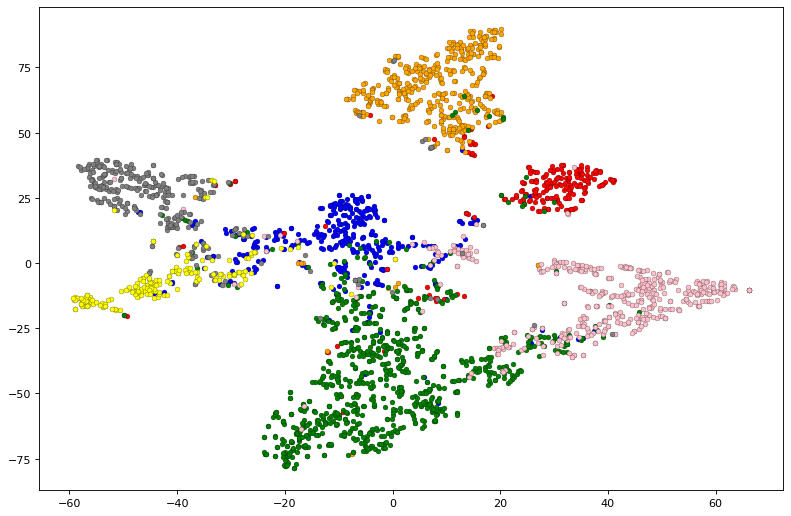

In [76]:
model_name=r'gat_000001.pth'  # This model is checked-in, feel free to use the one you trained
dataset_name=DatasetType.CORA.name


visualize_gat_properties(
        model_name,
        dataset_name,
        visualization_type=VisualizationType.EMBEDDINGS  # pick between attention, t-SNE embeddings and entropy
)

Awesome!! ✌

Description of the graph above: 

>once we do a forward pass through GAT, it transforms the input feature vectors of dimension (number of nodes, number of features per feature vector) = `(2708, 1433)` into `(2708, 7)` because Cora has 7 classes.

>The classes are: `Genetic Algorithms`, `Reinforcement Learning`, etc.

>Now once we've got those 7 dimensional vectors, we use t-SNE to map them into 2D vectors (*because it's hard to plot 7D vectors*). The trick with t-SNE is that it preserves the relationships between the vectors,i.e. if they were close in the 7D space they'll be close in the 2D space as well.

>Now you can see that points of the same class (they share the same color) are clustered together! And that's a desirable property because now it's much easier to train a classifier that'll correctly predict the class.


Now, it's time to focus on **Attention**

### 4-2 Visualizing neighborhood attention

During the aggregation stage every single node assigns an **attention coefficient** to every single one of its neighbors (including itself since we added self edges).


In [77]:
import cairocffi

In [78]:
# igraph is having some problems running in Jupyter 

# Fetch the data we'll need to create visualizations
all_nodes_unnormalized_scores, edge_index, node_labels, gat = gat_forward_pass(model_name, dataset_name)

# The number of nodes for which we want to visualize their attention over neighboring nodes
num_nodes_of_interest = 5  # 5 is an arbitrary number you can play with these numbers
head_to_visualize = 0  # plot attention from this multi-head attention's head (last layer only has a single head)
gat_layer_id = 1  # plot attention from this GAT layer (since our GAT only has 2 layers this is the last layer)

# Build up the complete graph
# node_features shape = (N, FIN), where N is the number of nodes and FIN number of input features
total_num_of_nodes = len(node_features)
complete_graph = ig.Graph()
complete_graph.add_vertices(total_num_of_nodes)  # igraph creates nodes with ids [0, total_num_of_nodes - 1]
edge_index_tuples = list(zip(edge_index[0, :], edge_index[1, :]))  # igraph requires this format
complete_graph.add_edges(edge_index_tuples)

# Pick the target nodes to plot (nodes with highest degree + random nodes)
# Note: there could be an overlap between random nodes and nodes with highest degree - but highly unlikely
highest_degree_node_ids = np.argpartition(complete_graph.degree(), -num_nodes_of_interest)[-num_nodes_of_interest:]
random_node_ids = np.random.randint(low=0, high=total_num_of_nodes, size=num_nodes_of_interest)

print(f'Highest degree nodes = {highest_degree_node_ids}')
      
target_node_ids = edge_index[1]
source_nodes = edge_index[0]


# Pick the node id you want to visualize the attention for!


# since for loops won't work with igraph just set some number here
target_node_id = 306  # 306 is the 2nd highest degree node

# Step 1: Find the neighboring nodes to the target node
# Note: self edge for CORA is included so the target node is its own neighbor
src_nodes_indices = torch.eq(target_node_ids, target_node_id)
source_node_ids = source_nodes[src_nodes_indices].cpu().numpy()
size_of_neighborhood = len(source_node_ids)

# Step 2: Fetch their labels
labels = node_labels[source_node_ids].cpu().numpy()

# Step 3: Fetch the attention weights for edges (attention is logged during GAT's forward pass above)
# attention shape = (N, NH, 1) -> (N, NH) 
all_attention_weights = gat.gat_net[gat_layer_id].attention_weights.squeeze(dim=-1)
attention_weights = all_attention_weights[src_nodes_indices, head_to_visualize].cpu().numpy()
# This part shows that for CORA what GAT learns is pretty much constant attention weights! Like in GCN!
print(f'Max attention weight = {np.max(attention_weights)} and min = {np.min(attention_weights)}')
attention_weights /= np.max(attention_weights)  # rescale the biggest weight to 1 for nicer plotting

# Build up the neighborhood graph whose attention we want to visualize
# igraph constraint - it works with contiguous range of ids so we map e.g. node 497 to 0, 12 to 1, etc.
id_to_igraph_id = dict(zip(source_node_ids, range(len(source_node_ids))))
ig_graph = ig.Graph()
ig_graph.add_vertices(size_of_neighborhood)
ig_graph.add_edges([(id_to_igraph_id[neighbor], id_to_igraph_id[target_node_id]) for neighbor in source_node_ids])

# Prepare the visualization settings dictionary and plot
visual_style = {
    "edge_width": attention_weights,  # make edges as thick as the corresponding attention weight
    "layout": ig_graph.layout_reingold_tilford_circular()  # layout for tree-like graphs
}
# This is the only part that's Cora specific as Cora has 7 labels
if dataset_name.lower() == DatasetType.CORA.name.lower():
    visual_style["vertex_color"] = [cora_label_to_color_map[label] for label in labels]
else:
    print('Add custom color scheme for your specific dataset. Using igraph default coloring.')

ig.plot(ig_graph, **visual_style)


***** Model training metadata: *****
dataset_name: CORA
num_of_epochs: 10000
test_acc: 0.835
num_of_layers: 2
num_heads_per_layer: [8, 1]
num_features_per_layer: [1433, 8, 7]
add_skip_connection: False
bias: True
dropout: 0.6
*************************************

Highest degree nodes = [1810 1986 1701  306 1358]
Max attention weight = 0.013349808752536774 and min = 0.012062188237905502


AttributeError: ignored

Unfortunately, igraph again has problem with jupyter... The code above running correctly but here in jupyter it doesn't work :(



###4-3 Visualizing entropy histograms

What is entropy?

>The attention coefficients sum up to 1 - they form a probability distribution. Where there is a probability distribution you can calculate the entropy. And the entropy quantifies the amount of information in a distribution. very simple explained.


The main idea:

>If we have a **"hypothetical" GAT** that has a constant attention over every node's neighborhood (i.e. **all distributions are uniform**), and we calculate the entropy of each and every neighborhood, and we make a histogram out of those numbers - **how different are the histograms** coming from it compared to the GAT we just trained?

>If the answer is they completely *overlap*, well that means our GAT has got uniform attention patterns. The smaller the overlap, the less uniform the distributions are. What we care about is how much the histograms **match**.


***** Model training metadata: *****
dataset_name: CORA
num_of_epochs: 10000
test_acc: 0.835
num_of_layers: 2
num_heads_per_layer: [8, 1]
num_features_per_layer: [1433, 8, 7]
add_skip_connection: False
bias: True
dropout: 0.6
*************************************



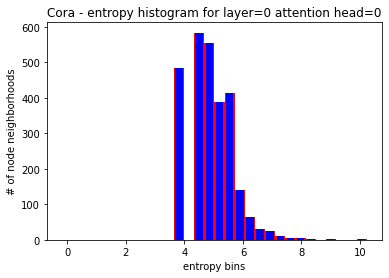

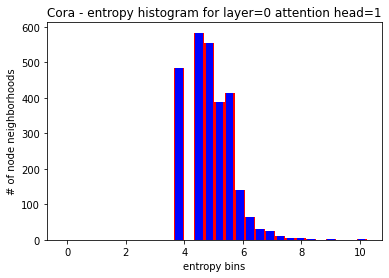

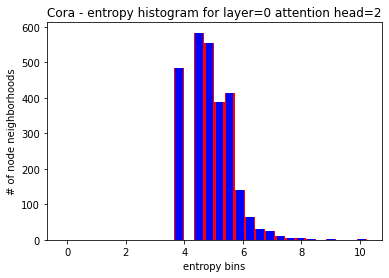

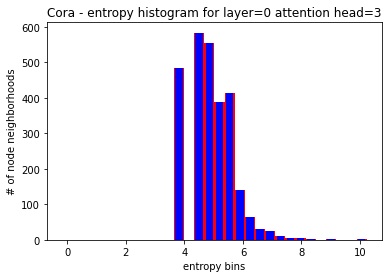

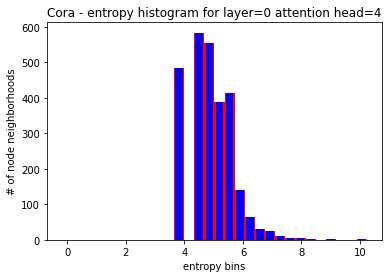

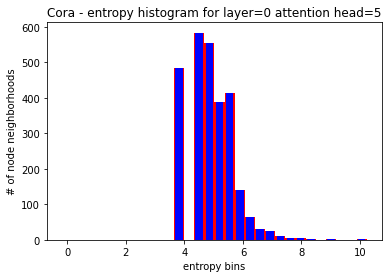

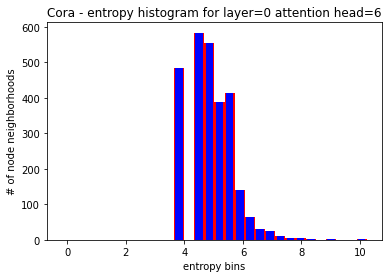

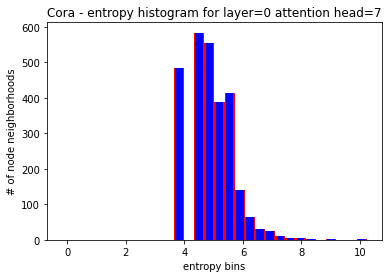

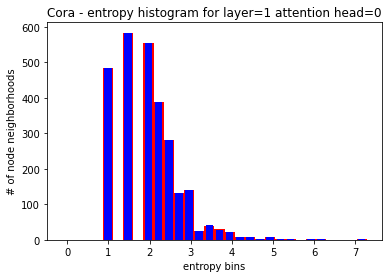

In [79]:
visualize_gat_properties(
        model_name,
        dataset_name,
        visualization_type=VisualizationType.ENTROPY  # pick between attention, t-SNE embeddings and entropy
)

**Perfect** 

The blue histograms (trained GAT) completely match the red ones (uniform attention GAT).

